In [1]:
import regex as re
import numpy as np
from statistics import mean, stdev
import matplotlib
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#from bento_bench import bar_plot, parse_elapsed_secs, get_avg_from_table_str, set_size
import pandas as pd
import json
import os
import seaborn as sns
import dpfs
from dpfs import *
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    #"pgf.texsystem": "pdflatex",
    "font.family": "serif",
    #"font.serif": 'DejaVu Serif',
    #'text.usetex': False,
#     'pgf.rcfonts': False,
    "font.size": 18,
    #"font.weight": "bold",
    'ps.useafm': True,
    "pdf.use14corefonts": True,
    "text.usetex": True,
})

TARGET = "./thesis/"
OUT = TARGET + "/out/"

In [2]:
# DPFS-NULL-pre (including MP)
df = parse_fio(["randread", "randwrite"], ["4k", "16k", "64k"],
               ["2", "4", "8", "16", "32", "64", '128'],
               ["1", "2", "4", "8"], "DPFS-NULL-pre", TARGET+"/DPFS-NULL-pre/")
s = parse_fio(["randread", "randwrite"], ["4k", "16k", "64k"],
               ["1"],
               ["1"], "DPFS-NULL-pre", TARGET+"/DPFS-NULL-pre/")
df = pd.concat((s, df), ignore_index=True)

# DPFS-NFS-pre
s = parse_fio(["randread", "randwrite"], ["4k", "16k", "64k"],
               ["1", "2", "4", "8", "16", "32", "64", '128'],
               ["1"], "DPFS-NFS-pre", TARGET+"/DPFS-NFS-pre/")
df = pd.concat((s, df), ignore_index=True)

# DPFS-NFS-post
s = parse_fio(["randread", "randwrite"], ["4k", "16k", "64k"],
               ["1", "2", "4", "8", "16", "32", "64", '128'],
               ["1"], "DPFS-NFS-post", TARGET+"/DPFS-NFS-post/")
df = pd.concat((s, df), ignore_index=True)

print(df)

df_clat = parse_fio_clat(["randread", "randwrite"], ["4k"], ["1"], ["1"], "DPFS-NFS-pre", TARGET+"/DPFS-NFS-pre/")
s = parse_fio_clat(["randread", "randwrite"], ["4k"], ["1"], ["1"], "DPFS-NFS-post", TARGET+"/DPFS-NFS-post/")
df_clat = pd.concat((s, df_clat), ignore_index=True)

              conf         RW   BS   QD  P  IOPS_avg  IOPS_stdev  clat_avg  \
0    DPFS-NFS-post   randread   4k    1  1  10987.19       75.34     85.86   
1    DPFS-NFS-post   randread   4k    2  1  20358.78      153.70     93.39   
2    DPFS-NFS-post   randread   4k    4  1  29877.17      137.43    129.07   
3    DPFS-NFS-post   randread   4k    8  1  52520.12     3843.06    147.61   
4    DPFS-NFS-post   randread   4k   16  1  59052.25     3275.57    266.29   
..             ...        ...  ...  ... ..       ...         ...       ...   
265  DPFS-NULL-pre  randwrite  64k   64  8  72332.77     2983.79   7209.97   
266  DPFS-NULL-pre  randwrite  64k  128  1  74351.35      342.55   1720.45   
267  DPFS-NULL-pre  randwrite  64k  128  2  74048.97     2990.56   3490.97   
268  DPFS-NULL-pre  randwrite  64k  128  4  73392.82     3585.12   7103.90   
269  DPFS-NULL-pre  randwrite  64k  128  8  74422.38     5596.76  14804.36   

     clat_stdev       bw_avg    bw_stdev  
0         16.81    4

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



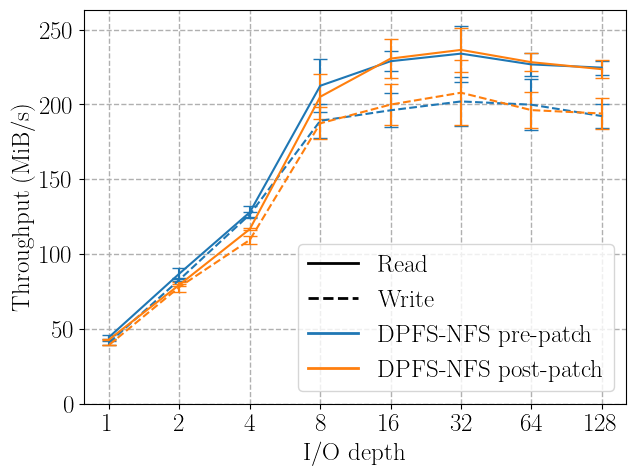

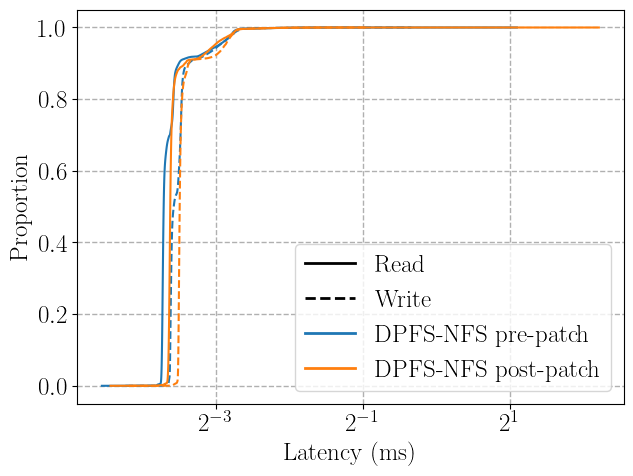

In [3]:
# Experiment 1.1
plot_tp(df, {'DPFS-NFS-pre': 'DPFS-NFS pre-patch ', 'DPFS-NFS-post': 'DPFS-NFS post-patch '}, '1',
        ['4k'], None,
        {'DPFS-NFS-pre': 'tab:blue', 'DPFS-NFS-post': 'tab:orange'}
        , False, OUT+"/DPFS-NFS-patch_tp.pdf")
# Experiment 1.2
plot_cdf(df_clat, {'DPFS-NFS-pre': 'DPFS-NFS pre-patch ', 'DPFS-NFS-post': 'DPFS-NFS post-patch '},
         "1", "1", "4k", ["randread", "randwrite"],
         {'DPFS-NFS-pre': 'tab:blue', 'DPFS-NFS-post': 'tab:orange'}, OUT+"/DPFS-NFS-patch_cdf.pdf")